# Students:

### Le Hoang Sang

### Vu Dinh Chuong

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
import torch.optim as optim

# CLean data

In [198]:
def clean_data(df):
    print("Initial data information:")
    print(df.info())

    # Remove unnecessary columns (if there are columns named 'Unnamed')
    df = df.loc[:, ~df.columns.get_level_values(1).str.contains('^Unnamed')]

    # Handle the 'timestamp' column (if present)
    if ('timestamp', '') in df.columns:
        # Convert to datetime format
        df[('timestamp', '')] = pd.to_datetime(df[('timestamp', '')], errors='coerce')  
        
        # Remove rows with missing timestamp values
        df = df.dropna(subset=[('timestamp', '')]) 

    # Fill missing values using forward fill and backward fill methods
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize 'close' values between 0 and 1 if present
    if ('close', '') in df.columns:
        df[('close', '')] = (df[('close', '')] - df[('close', '')].min()) / (df[('close', '')].max() - df[('close', '')].min())

    # Print out the data after cleaning
    print("Data after cleaning:")
    print(df.head())

    return df


# Create features

In [199]:
def create_features(df):
    df_features = df.copy()

    print("Column names in the DataFrame:", df_features.columns)

    # Define the symbol you want to work with (e.g., 'A', 'AAL', etc.)
    symbol = 'A'

    # Define the columns for the selected stock symbol
    numeric_cols = [(symbol, 'open'), (symbol, 'high'), (symbol, 'low'), (symbol, 'close'), (symbol, 'volume')]

    # Check if these columns exist in the DataFrame
    existing_cols = [col for col in numeric_cols if col in df_features.columns]

    if not existing_cols:
        raise ValueError("Required numeric columns not found in the DataFrame.")

    # Convert the necessary columns to numeric type
    df_features[existing_cols] = df_features[existing_cols].apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN values after conversion
    df_features = df_features.dropna()

    # Create features if the necessary columns exist
    if (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'return')] = df_features[(symbol, 'close')].pct_change()
        df_features[(symbol, 'ma7')] = df_features[(symbol, 'close')].rolling(window=7).mean()
        df_features[(symbol, 'ma21')] = df_features[(symbol, 'close')].rolling(window=21).mean()
        df_features[(symbol, 'volatility')] = df_features[(symbol, 'close')].rolling(window=7).std()
    
    if (symbol, 'open') in df_features.columns and (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'open_close_ratio')] = df_features[(symbol, 'open')] / df_features[(symbol, 'close')]
    
    if (symbol, 'high') in df_features.columns and (symbol, 'low') in df_features.columns:
        df_features[(symbol, 'high_low_ratio')] = df_features[(symbol, 'high')] / df_features[(symbol, 'low')]

    # Remove rows with NaN values due to calculations
    df_features = df_features.dropna()  

    print("DataFrame with new features:")
    print(df_features.head())

    return df_features

# Plot data

In [200]:
def plot_features(df_features, symbol='A'):
    # Ensure symbol exists in the DataFrame
    if symbol not in df_features.columns.get_level_values(0):
        raise ValueError(f"Symbol '{symbol}' not found in DataFrame columns.")

    # Plot the 'close' price
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'close')], label=f'{symbol} Close Price', color='b')
    plt.title(f'{symbol} Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Plot the 7-day and 21-day moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'ma7')], label=f'{symbol} MA7', color='g')
    plt.plot(df_features.index, df_features[(symbol, 'ma21')], label=f'{symbol} MA21', color='r')
    plt.title(f'{symbol} 7-day and 21-day Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot the volatility (7-day rolling standard deviation)
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'volatility')], label=f'{symbol} Volatility (7-day)', color='purple')
    plt.title(f'{symbol} Volatility (7-day rolling std)')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

    # Plot the open/close ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'open_close_ratio')], label=f'{symbol} Open/Close Ratio', color='orange')
    plt.title(f'{symbol} Open/Close Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

    # Plot the high/low ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'high_low_ratio')], label=f'{symbol} High/Low Ratio', color='brown')
    plt.title(f'{symbol} High/Low Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

# Run flow

In [201]:
df = pd.read_csv('./newfile.csv', index_col=0, header=[0, 1]).sort_index(axis=1)

# Drop the 'Adj Close' column
df.drop('Adj Close', axis=1, inplace=True)

In [202]:
df_cleaned = clean_data(df)

Initial data information:
<class 'pandas.core.frame.DataFrame'>
Index: 8371 entries, 2024-11-18 14:31:00+00:00 to 2024-12-18 16:52:00+00:00
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (Close, 226.1999969482422)  8371 non-null   float64
 1   (High, 226.41000366210932)  8371 non-null   float64
 2   (Low, 225.17999267578125)   8371 non-null   float64
 3   (Open, 225.1999969482422)   8371 non-null   float64
 4   (Volume, 1331036.0)         8371 non-null   float64
dtypes: float64(5)
memory usage: 392.4+ KB
None
Data after cleaning:
Date                                  Close               High  \
2024-11-18 14:30:00+00:00 226.1999969482422 226.41000366210932   
2024-11-18 14:31:00+00:00        226.565994         226.639999   
2024-11-18 14:32:00+00:00        226.679993         226.880005   
2024-11-18 14:33:00+00:00        226.410004         226.820007   
2024-11-18 14:34:00+00:00     

C:\Users\LT MSI\AppData\Local\Temp\ipykernel_8708\1215159712.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [203]:
# Split train from  11/09/2017 9:30 A.M. to 17/01/2018 11:50 A.M and test data  from 17/01/2018 11:51A.M. to 16/02/2018 03:59A.M
train = df.loc['2024-11-18 14:30:00+00:00':'2024-12-12 19:40:00+00:00']
test = df.loc['2024-12-12 19:41:00+00:00':'2024-12-18 16:52:00+00:00']

In [204]:
# Create sequences of data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Create sequences with a length of 100
seq_length = 100
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Create data loaders
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [205]:
class VanillaLSTM(nn.Module):
    def __init__(self, num_feature):
        super(VanillaLSTM, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = VanillaLSTM(5)

In [206]:
# RMSE loss function
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [207]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y = batch
        pred = model(x)
        loss = criterion(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [208]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = criterion(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [209]:
n_epochs = 600
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):
    train_loss = train(train_loader)
    valid_loss = evaluate(test_loader)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, './checkpoint/saved_weights.pt')

    if (epoch % 200 == 0):
        print(f'\tEpoch: {epoch} | ' + f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

KeyboardInterrupt: 

In [100]:
model=torch.load('./checkpoint/saved_weights.pt')

/var/folders/m1/kw3tpwys1m5bzfrsgxqkn4140000gn/T/ipykernel_74109/1530574977.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('./checkpoint/saved_weights.

In [101]:
X_test = torch.tensor(X_test).float()

with torch.no_grad():
  y_test_pred = model(X_test)

y_test_pred = y_test_pred.numpy()[0]


# # test y_test_pred first column
# y_pred_close = y_test_pred[:, :1]
# y_test_close = y_test[:, :1]

/var/folders/m1/kw3tpwys1m5bzfrsgxqkn4140000gn/T/ipykernel_74109/4085121183.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()


In [102]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['Close','High','Low','Open','Volume'])
results

,Close,High,Low,Open,Volume
RMSE,0.016118,0.012564,0.013455,0.008240,0.044895
MSE,0.000260,0.000158,0.000181,0.000068,0.002016
MAE,0.011227,0.009077,0.008240,0.003858,0.017105
R2 score,0.997388,0.998394,0.998197,0.999317,0.680012


In [103]:
# error number of all columns
error = np.abs(y_test - y_test_pred)
error = pd.DataFrame(error, columns=['Close','High','Low','Open','Volume'])
error

,Close,High,Low,Open,Volume
0,0.014326,0.014815,0.004435,0.004469,0.007554
1,0.005291,0.005007,0.002757,0.000304,0.005484
2,0.009151,0.006002,0.008425,0.002244,0.004020
3,0.014816,0.002746,0.006962,0.000056,0.008180
4,0.018141,0.010279,0.020280,0.002396,0.015210
...,...,...,...,...,...
1319,0.008775,0.008649,0.006316,0.001368,0.008175
1320,0.000555,0.010387,0.006761,0.005265,0.000123
1321,0.017440,0.003076,0.008730,0.001156,0.002402
1322,0.017946,0.001093,0.010928,0.003239,0.009740


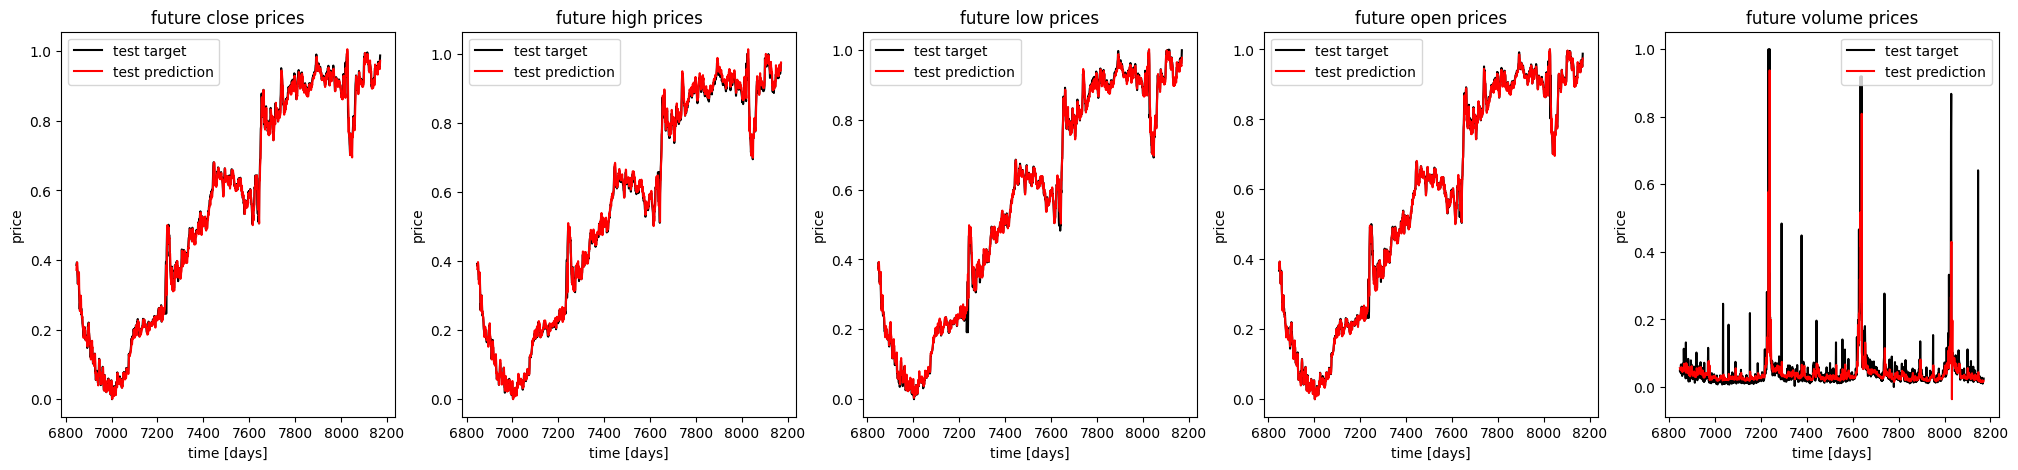

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figwidth(25)
fig.set_figheight(5)

for i in range(5):
    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future close prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future open prices')
ax[4].set_title('future volume prices')

plt.show()

In [118]:
# Predicting the next 100 mins

seq_len = 51
sequences = []
for index in range(len(test) - seq_len + 1): 
    sequences.append(test[index: index + seq_len])
sequences = np.array(sequences)

last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions
PREDICT = 50
with torch.no_grad():
    for i in range(PREDICT):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_mins = last_sequence.reshape(PREDICT, 5).numpy()

# # Inverse transform the predicted values
pred_value = scaler.inverse_transform(pred_mins)

df_pred = pd.DataFrame(
    data=pred_value,
    columns=['Close','High','Low','Open','Volume']
)

df_pred

,Close,High,Low,Open,Volume
0,252.907639,251.236954,248.847275,248.851562,-2.204978e+06
1,245.771149,246.995636,245.917587,247.129044,2.450839e+05
2,247.310043,247.452988,247.037140,247.203964,1.817387e+05
3,248.788742,249.041977,248.498489,248.620056,4.936268e+05
4,249.344727,249.514023,249.114334,249.192108,2.662547e+05
5,249.427994,249.585266,249.261307,249.323822,2.217497e+05
6,249.735291,249.857895,249.605194,249.641983,2.898291e+05
7,249.740967,249.851700,249.646011,249.680130,2.301119e+05
8,249.733765,249.841446,249.663147,249.690536,2.331528e+05
9,249.748505,249.857422,249.684082,249.706543,2.837050e+05


In [119]:
# Get error of last 50 mins
error_pred = np.abs(y_test[-50:] - pred_mins)

x = scaler.inverse_transform(y_test[-50:])
y = scaler.inverse_transform(pred_mins)

# error_pred = scaler.inverse_transform(error_pred)

error_pred = np.abs(x - y)

error_pred = pd.DataFrame(error_pred , columns=['Close','High','Low','Open','Volume'])

x = pd.DataFrame(x, columns=['Close','High','Low','Open','Volume'])

y = pd.DataFrame(y, columns=['Close','High','Low','Open','Volume'])

print('Actual dataset')
print(x)

print('Predicted dataset')
print(y)

print('Error dataset')
print(error_pred)

Actual dataset
         Close        High         Low        Open     Volume
0   253.259995  253.429993  253.259995  253.419998    45408.0
1   253.269806  253.285706  253.199997  253.274994    54848.0
2   253.250000  253.320007  253.218704  253.272705    32067.0
3   253.330002  253.335007  253.244995  253.249893    51211.0
4   253.455795  253.479996  253.440094  253.479996   102151.0
5   253.399994  253.475998  253.399994  253.460007    25641.0
6   253.390503  253.408707  253.330002  253.399994    34551.0
7   253.339996  253.406799  253.335007  253.389999    35709.0
8   253.274994  253.350006  253.270004  253.339996    38300.0
9   253.259995  253.389893  253.227295  253.274994    32811.0
10  253.020004  253.250000  253.020004  253.250000    82993.0
11  252.979996  253.100006  252.970001  253.039993    69882.0
12  252.925003  252.989899  252.910004  252.985001    82528.0
13  253.000000  253.000000  252.940002  252.945007    55085.0
14  252.940002  253.000000  252.869995  253.000000    5

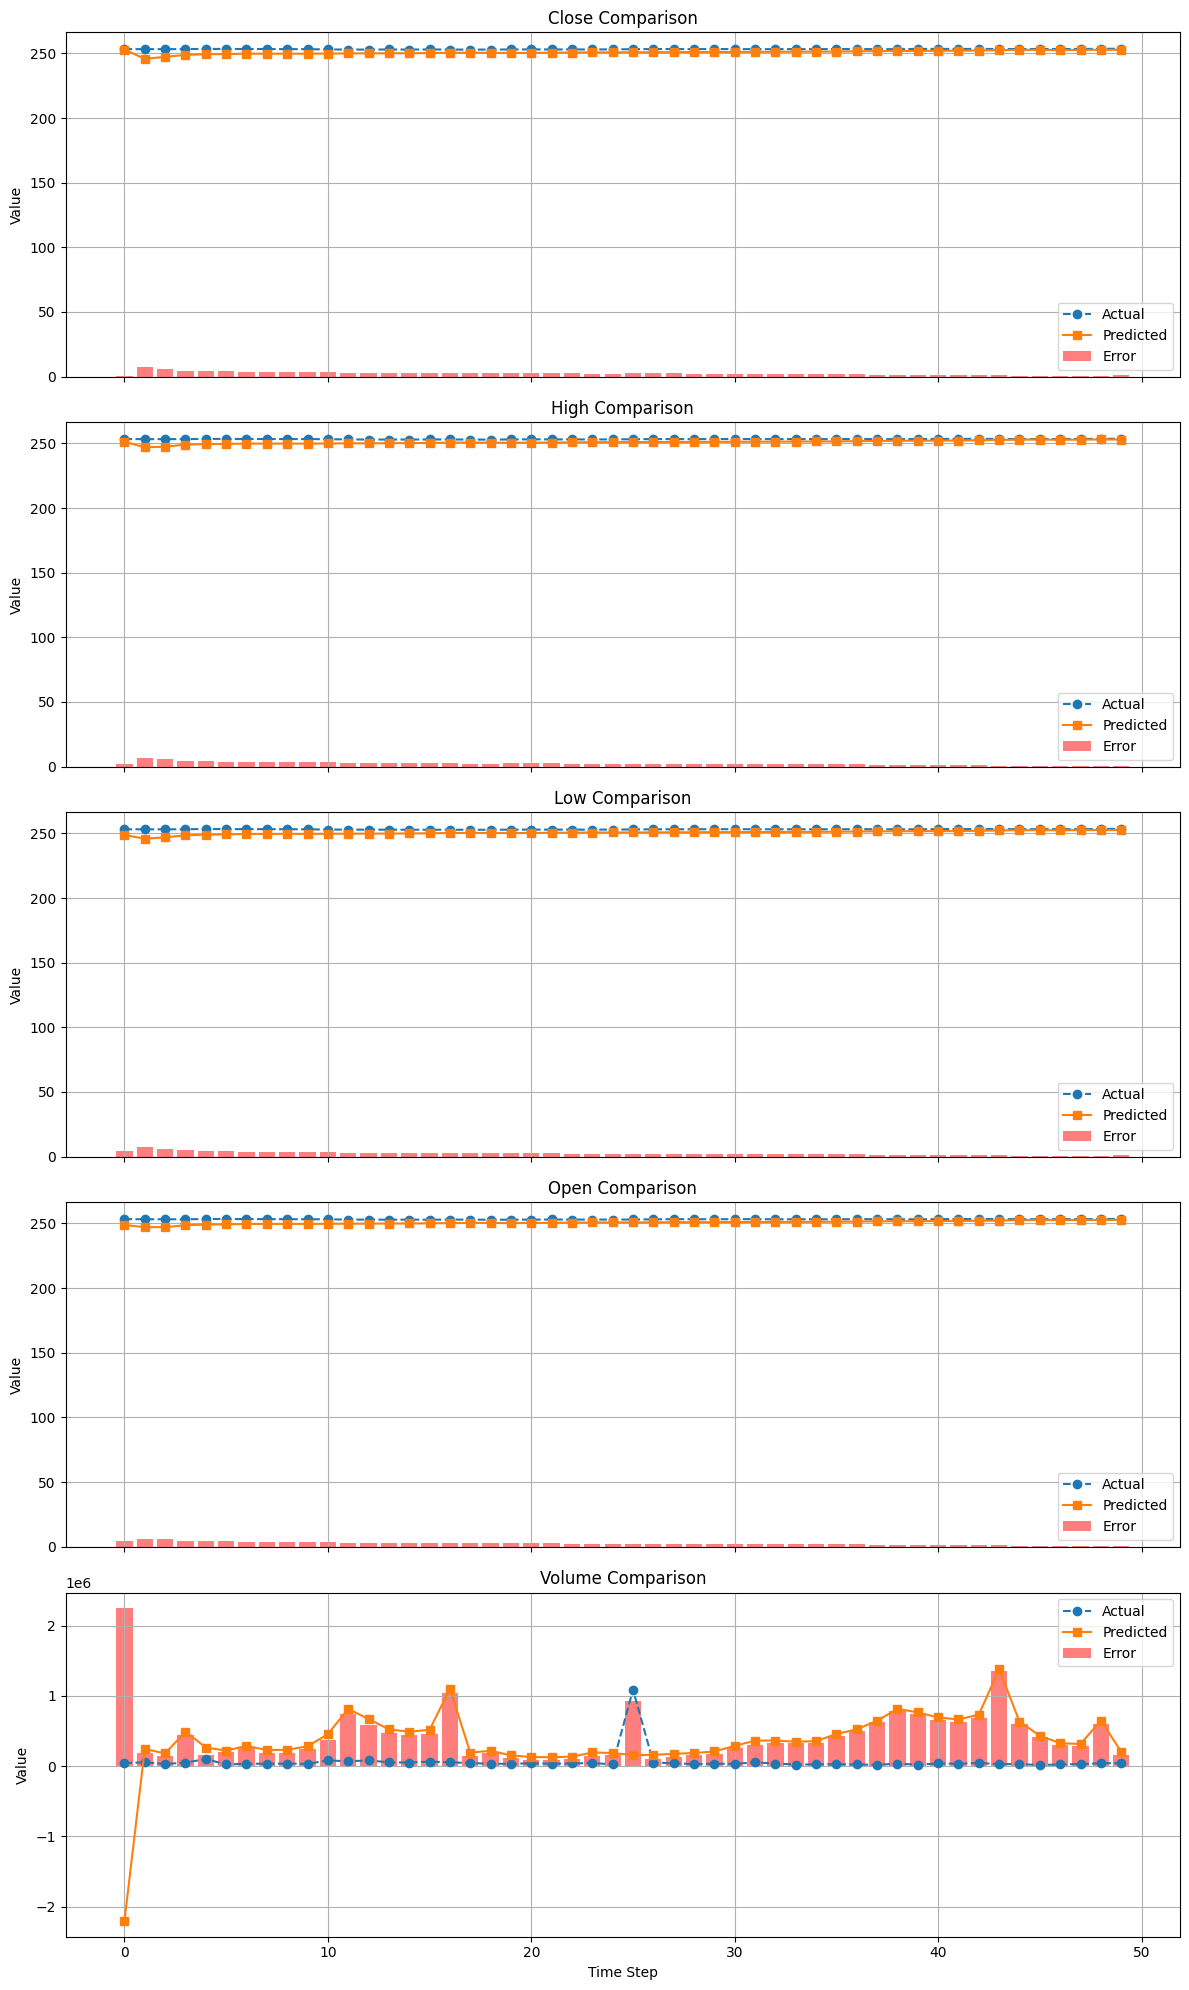

In [120]:
# Plotting the comparison for Actual, Predicted, and Error datasets
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)

columns = ['Close', 'High', 'Low', 'Open', 'Volume']
for i, column in enumerate(columns):
    axes[i].plot(x.index, x[column], label='Actual', marker='o', linestyle='--')
    axes[i].plot(y.index, y[column], label='Predicted', marker='s', linestyle='-')
    axes[i].bar(error_pred.index, error_pred[column], alpha=0.5, label='Error', color='red')
    axes[i].set_title(f'{column} Comparison')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Time Step')

plt.tight_layout()
plt.show()